In [14]:
import pyro
import torch
import numpy as np
import pandas as pd
import pyro.distributions as dist
import scipy.stats
from matplotlib import pyplot as plt
from pyro.infer.mcmc import MCMC, NUTS

In [9]:
y_obs = torch.Tensor([1, -1, 2, 5, 7])
mean_z = 0
std_z = 1
std_y = 1

def model():
    z = pyro.sample('z', dist.Normal(mean_z, std_z))
    y = pyro.sample('y', dist.Normal(z, std_y), obs=y_obs)
    return y

nuts_kernel = NUTS(model)
mcmc_sampler = MCMC(nuts_kernel, num_samples=4000, warmup_steps=2000)
posterior = mcmc_sampler.run()

def map_sites(func, posterior, sites):
    marginal = posterior.marginal(sites)
    site_stats = {}
    for site in sites:
        marginal_site = marginal.support(flatten=True)[site]
        site_stats[site] = func(marginal_site.numpy(), site)
    return site_stats

def get_site_stats(array, name):
    if len(array.shape) == 1:
        names = [name]
    else:
        names = ["{}[{}]".format(name, i) for i in range(array.shape[1])]
    print(names, array.shape)
    array_ = array.reshape(array.shape[0],-1)
    df = pd.DataFrame(array_, columns=names).transpose()
    return df.apply(pd.Series.describe, axis=1)[["mean", "std", "25%", "50%", "75%"]]


sites = ["z"]
summary = pd.concat([s for s in map_sites(get_site_stats, posterior, sites).values()])
print(summary)

Sample: 100%|██████████| 6000/6000 [00:16<00:00, 374.55it/s, step size=9.35e-01, acc. prob=0.935]


['z'] (4000,)
       mean       std      25%       50%       75%
z  2.341591  0.403129  2.06888  2.352011  2.610176


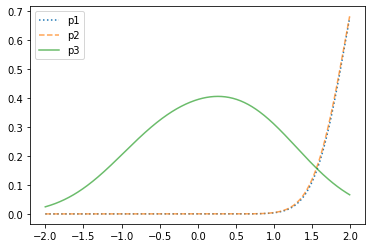

In [16]:
p1 = scipy.stats.norm(summary['mean'], summary['std']).pdf

def p2 (x):
    prior = scipy.stats.norm(mean_z, std_z).pdf(x)
    tmp = np.array([scipy.stats.norm(x, std_y).pdf(y_obs[i]) for i in range(y_obs.shape[0])])
    likelihood = np.prod(tmp, axis=0)
    return likelihood * prior

def p3 (x):
    prior = scipy.stats.norm(mean_z, std_z).pdf(x)
    tmp = np.array([scipy.stats.norm(x, std_y).pdf(y_obs[i]) for i in range(y_obs.shape[0])])
    likelihood = np.mean(tmp, axis=0)
    return likelihood * prior

x_range = np.arange(-2, 2, 0.01)
y1 = p1(x_range)
y2 = p2(x_range)/scipy.integrate.quad(p2, -20, 20)[0]
y3 = p3(x_range)/scipy.integrate.quad(p3, -20, 20)[0]

plt.plot(x_range, y1, ":", label='p1')
plt.plot(x_range, y2, "--", label='p2', alpha=0.7)
plt.plot(x_range, y3, "", label='p3', alpha=0.7)
plt.legend(loc='best')

In [2]:
pyro.set_rng_seed(101)

In [88]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(0.3136)
log prob tensor(-0.9681)


In [404]:
probs = torch.Tensor([0.1,0.3, 0.4, 0.5, 0.6, 0.7, 0.9])
print(torch.distributions.Bernoulli(probs).sample())

print(torch.distributions.Bernoulli(0.5).sample())

tensor([0., 0., 1., 1., 1., 1., 1.])
tensor(0.)


In [111]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

weather()

('sunny', 72.83492279052734)

In [130]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(1.5210)


In [169]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    print(type(cloudy), cloudy)
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

<class 'torch.Tensor'> tensor(0.)
('sunny', 81.97663879394531)
<class 'torch.Tensor'> tensor(0.)
('sunny', 78.90469360351562)
<class 'torch.Tensor'> tensor(0.)
('sunny', 63.31127166748047)


In [170]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................
based on the data and our prior belief, the fairness of the coin is 0.536 +- 0.090


In [295]:
x_train = torch.Tensor([0.7,0.6, 0.1, 0.3])
y_train = torch.Tensor([1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,])
y_obs = pyro.sample("y_obs", dist.Bernoulli(torch.sigmoid(x_train)), obs=y_train)
y_obs.numpy()


array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)